In [6]:
# coding: utf-8
import numpy as np 
import pandas as pd 
import cv2
import os 
import matplotlib.pyplot as plt
import random

# from utils import show_loss
from cls_loss import  *
from utils import *
from conf import train_config

data_foler = train_config.data_foler

# To prepare data
data_train = pd.read_csv(train_config.train_csv_path)
data_val = pd.read_csv(train_config.val_csv_path)
data_train_mb = data_train.loc[data_train[train_config.gt_class] == 1]
data_val_mb = data_val.loc[data_val[train_config.gt_class] == 1]

VALID_IMG_COUNT = len(data_val_mb)
print('The number of val data is {}'.format(VALID_IMG_COUNT))
valid_x, valid_y = next(make_image_gen2d(data_val_mb, VALID_IMG_COUNT))
aug_gen = make_image_gen2d(data_train_mb, if_aug = True) #use imgaug s


## Training parameter preparation for call_bask
from utils import call
callbacks_list = call(
         weight_path = train_config.best_model_save_path, 
         monitor = train_config.monitor , 
         mode = train_config.mode, 
         reduce_lr_p = train_config.reduce_lr_p, 
         early_p = train_config.early_p, 
         log_csv_path = train_config.log_csv_path,
         save_best_only = train_config.save_best_only, 
         save_weights_only = train_config.save_weights_only,
         num_train = 5000, #train_IMG_COUNT
         factor=0.5,
         epsilon=0.0001,
         cooldown=2,
         min_lr=train_config.min_lr,
         verbose=1)

#Prepare model
import keras
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from classification_models.resnet import ResNet34

model = DenseNet121(weights = train_config.encoder_weights, 
                 include_top= train_config.include_top, 
                 input_shape=(train_config.image_size*2, train_config.image_size*2, 3))
 
from keras.models import Model
def get_model(model,numclasses):
    base_model = model 
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(train_config.dropout_rate)(x) #
    predictions = keras.layers.Dense(numclasses, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    new_model = Model(inputs=base_model.input, outputs=base_model.output)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = train_config.base_model_layer_trainable
    return model, new_model

#There are two models, one is to save the entire model, and one is not to save the top layer
model, new_model = get_model(model, 1)
from keras.utils import multi_gpu_model ##
muti_model = multi_gpu_model(model, gpus=2) ##


muti_model.compile(
              loss=[focal_loss(alpha=.25, gamma=2)], 
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=train_config.metrics)
MAX_TRAIN_STEPS = train_config.MAX_TRAIN_STEPS
step_count = min(train_config.MAX_TRAIN_STEPS, data_train.shape[0]//train_config.BATCH_SIZE) 

The number of val data is 408


In [7]:
from clr import *
lr_finder = LRFinder(muti_model)
lr_finder.find_gen(aug_gen, start_lr=0.0000001, end_lr=100, num_train = 5000, batch_size=80, epochs=3)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
# plt.show()

Epoch 1/3
63/62 [==============================] - 144s 2s/step - loss: 14.5332 - acc: 0.3832
Epoch 2/3
63/62 [==============================] - 110s 2s/step - loss: 0.9277 - acc: 0.9468
Epoch 3/3
63/62 [==============================] - 111s 2s/step - loss: 2.7049e-09 - acc: 1.0000


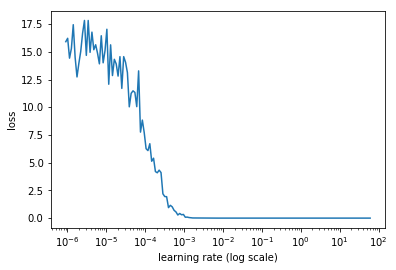

In [8]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()